# Deep Learning Part 2 : Lab 4
## Autoencoders 
**GEC Academy: Winter 2019**  
**Instructor**: Pavlos Protopapas,  
**TFs :** Patrick Ohiomoba, Srivatsan Srinivasan

---

## Table of Contents

1. [Introduction](#Introduction)
2. [Autoencoder Basics](#Preliminaries)
3. [A Simple Fully Connected Autoencoder on MNIST](#Floydhub)


## Introduction

In the last two lectures, we've continued our exploration of Deep Learning by learning about Representational Learning, Autoencoders, some alternative autoencoder architectures (Denoising Autoencoders, Convolutional Autoencoders, Sparse Autoencoders, Contractive Autoencoders, etc...) and went over in detail one generative class of autoencoders in particular Variational Autoencoders. In today's lab we will buttress our knowledge of this interesting type of unsupervised Deep Learning models by constructing (and analyzing) some implementations of autoencoders in Keras.  

## Autoencoder Basics

We learned in Lectures 4 and 5 what all about the various forms of autoencoders in deep learning, but as we often do let's turn to [Wikipedia](https://www.wikipedia.com) for a definition.  There we'll find that [autoencoders](https://en.wikipedia.org/wiki/Autoencoder) 

> An autoencoder is a type of artificial neural network used to learn efficient data codings in an unsupervised manner/   The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore signal “noise.” Along with the reduction side, a reconstructing side is learnt, where the autoencoder tries to generate from the reduced encoding a representation as close as possible to its original input, hence its name. Recently, the autoencoder concept has become more widely used for learning generative models of data.


![stole from Lecture](./images/autoencoder_lecture.png)

Autoencoders perform their task -- whether that be compression, denoising or something else in an unsupervised way.  Let's assume we're creating an autoencoder for the purposes of data compression.  An autoencoder would not perform data compression in the same way that algorithms like JPEG or MPEG might -- on the basis of some overarching assumptions relating to the properties of sound, image and video data that then influence a resultant deterministic algorithm.   Autoencoders go about processing their input dataset and influenced by the examples within within automatically **learn** a lossy compression algorith. The resultant algorithm may generalize (largely depending on the completeness o the training data) but the algorithm is in reality specific to input data.


Autoencoders have 3 fundamental components:

- An Encoder (typically a neural network) approximating a function f(x) where x is the input
- A Decoder (typically a neural network) approximating a function g(y) where y is the output of the encoder
- A loss function (usually representing some metric on the difference between the original input x and g(f(x)) (i.e the output of encoding the input and decoding)


**Uses of Autoencoders**

- Data Denoising
- Image/Information Retrieval
- Anomaly/Fraud Detection
- Dimension Reduction


## A Simple Fully Connected Autoencoder on MNIST

Let's start as we often do by using the [MNIST data set](http://yann.lecun.com/exdb/mnist/) to explore a really simple  example of an autoencoder. Both our encoding and decoding network will be fully connected MLPs with 2 hidden layers.



#### Imports and Data Processing

In [0]:
import numpy as np
import pandas as pd

import keras
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Input, Reshape, UpSampling2D
from keras.utils import np_utils, to_categorical

from keras.datasets import mnist

import matplotlib.pyplot as plt
%matplotlib inline

We need to load the datat from the mnist dataset (which comes with Keras), normalize and reshape it and turn the labels into categoricals.  We'll borrow some code from Lab 1.

In [0]:
# Load data and preprocess
(train_images, train_labels), (test_images, test_labels) = mnist.load_data() # load MNIST data

train_images = train_images.reshape((60000, 784)) # Reshape to get third dimension
train_images = train_images.astype('float32') / 255 # Normalize between 0 and 1

test_images = test_images.reshape((10000, 784)) # Reshape to get third dimension
test_images = test_images.astype('float32') / 255 # Normalize between 0 and 1

# Convert labels to categorical data
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

#### Defining the Autoencoder

We're going to create an autoencoder by first defining an MLP (the encoder) that takes the 28x28 images in the MNIST database and  converts them into a latent representation of dimension 20.  The decoder part of our autoencoder will take that network and convert it back to an output space with size 784 (which we'll reshape back into our 28x28 images).

Let's start by building the encoder:

In [0]:
def build_mlp_encoder(input_size, bottleneck_size):

    mlp_model = Sequential() # Create sequential model

    # Add hidden layers
    mlp_model.add(Dense(128, activation='relu', input_shape=(input_size, )))
    mlp_model.add(Dense(64, activation='relu'))

    # bottleneck layer
    mlp_model.add(Dense(bottleneck_size, activation='relu'))

    return mlp_model


def build_mlp_decoder(input_size, bottleneck_size):
    
    mlp_model = Sequential() # Create sequential model

    # Add network layers
    mlp_model.add(Dense(64, activation='relu', input_shape= (bottleneck_size, )))    
    mlp_model.add(Dense(128, activation='relu'))

    mlp_model.add(Dense(input_size, activation='relu'))

    return mlp_model

In [4]:
mlp_encoder = build_mlp_encoder(784, 20)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
mlp_decoder = build_mlp_decoder(784, 20)

In [6]:
mlp_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1300      
Total params: 110,036
Trainable params: 110,036
Non-trainable params: 0
_________________________________________________________________


In [7]:
mlp_decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                1344      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_6 (Dense)              (None, 784)               101136    
Total params: 110,800
Trainable params: 110,800
Non-trainable params: 0
_________________________________________________________________


So now that we've built our encoder and decoder networks, let's put them together into our autoencoder.

In [0]:
def assemble_mlp_autoencoder(input_size, encoder, decoder):
    
    # assemble the inputs
    inputs = Input(shape=(input_size,))
    
    # encode the inputs
    encoding = encoder(inputs)
    
    # reconstruct the input from encoding
    reconstruction = decoder(encoding)

    autoencoder = Model(inputs=inputs, outputs=reconstruction)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

Now we can fit and train our model

In [9]:
mlp_autoencoder = assemble_mlp_autoencoder(784, mlp_encoder, mlp_decoder)

mlp_autoencoder.fit(x=train_images, y=train_images, epochs=15,
                validation_data=[test_images, test_images])

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 11s 192us/step - loss: 0.0293 - val_loss: 0.0223
Epoch 2/15
60000/60000 [==============================] - 11s 177us/step - loss: 0.0214 - val_loss: 0.0203
Epoch 3/15
60000/60000 [==============================] - 11s 179us/step - loss: 0.0201 - val_loss: 0.0193
Epoch 4/15
60000/60000 [==============================] - 11s 175us/step - loss: 0.0194 - val_loss: 0.0188
Epoch 5/15
60000/60000 [==============================] - 11s 178us/step - loss: 0.0189 - val_loss: 0.0182
Epoch 6/15
60000/60000 [==============================] - 11s 178us/step - loss: 0.0184 - val_loss: 0.0179
Epoch 7/15
60000/60000 [==============================] - 11s 180us/step - loss: 0.0178 - val_loss: 0.0173
Epoch 8/15
60000/60000 [==============================] - 11s 179us/step - loss: 0.0174 - val_loss: 0.0169
Epoch 9/15
60000/60000 [======================

As with the simple autoencoder, we randomly sample 10 test images (the same ones as before). The reconstructed digits look much better than those from the single-layer autoencoder. This observation aligns with the reduction in validation loss after adding multiple layers to the autoencoder.

Below, we plot the latent representation of all the MNIST test images and their groundtruth label. As we can see, the clusters are already grouped together quite nicely.

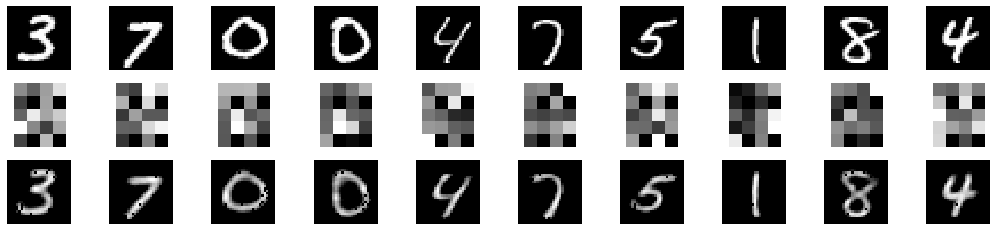

In [11]:
num_images = 10
random_test_images = np.random.randint(test_images.shape[0], size=num_images)

encoded_imgs = mlp_encoder.predict(test_images)
decoded_imgs = mlp_autoencoder.predict(test_images)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(test_images[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(5, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## A Convolutional Autoencoder on MNIST

Now that we've explored a simple fully connected autoencoder, let's use a convolutional autoencoder architecture instead. What this means is our encoding and decoding models will be **convolutional neural networks** instead of fully-connected networks.

To build the convolutional autoencoder, we'll make use of `Conv2D` and `MaxPooling2D` layers for the encoder and `Conv2D` and `UpSampling2D` layers for the decoder. The encoded images are transformed to a 3D array of dimensions `4 x 4 x 8`, but to visualize the encoding, we'll flatten it to a vector of length 128. I tried to use an encoding dimension of 32 like above, but I kept getting subpar results.

After the flattening layer, we reshape the image back to a `4 x 4 x 8` array before upsampling back to a `28 x 28 x 1` image.

In [20]:
autoencoder = Sequential()

# Encoder Layers
autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(8, (3, 3), strides=(2,2), activation='relu', padding='same'))

# Flatten encoding for visualization
autoencoder.add(Flatten())
autoencoder.add(Reshape((4, 4, 8)))

# Decoder Layers
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(16, (3, 3), activation='relu'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 8)           584       
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 8)           0         
__________

## Encoder Model

To extract the encoder model for the autoencoder, we're going to use a slightly different approach than before. Rather than extracting the first 6 layers, we're going to create a new `Model` with the same input as the autoencoder, but the output will be that of the flattening layer. As a side note, this is a very useful technique for grabbing submodels for things like [transfer learning](http://ruder.io/transfer-learning/).

As I mentioned before, the encoded image is a vector of length 128.

In [21]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('flatten_1').output)
encoder.summary()

ValueError: ignored

In [0]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 69s 1ms/step - loss: 0.1986 - val_loss: 0.1361
Epoch 2/100
60000/60000 [==============================] - 69s 1ms/step - loss: 0.1252 - val_loss: 0.1153
Epoch 3/100
60000/60000 [==============================] - 68s 1ms/step - loss: 0.1128 - val_loss: 0.1081
Epoch 4/100
60000/60000 [==============================] - 68s 1ms/step - loss: 0.1072 - val_loss: 0.1039
Epoch 5/100
60000/60000 [==============================] - 69s 1ms/step - loss: 0.1033 - val_loss: 0.1004
Epoch 6/100
60000/60000 [==============================] - 69s 1ms/step - loss: 0.1004 - val_loss: 0.0979
Epoch 7/100
60000/60000 [==============================] - 69s 1ms/step - loss: 0.0983 - val_loss: 0.0963
Epoch 8/100
60000/60000 [==============================] - 69s 1ms/step - loss: 0.0966 - val_loss: 0.0944
Epoch 9/100
60000/60000 [==============================] - 69s 1ms/step - loss: 0.0952 - val_loss: 0.0

The reconstructed digits look even better than before. This is no surprise given an even lower validation loss. Other than slight improved reconstruction, check out how the encoded image has changed. What's even cooler is that the encoded images of the 9 look similar as do those of the 8's. This similarity was far less pronounced for the simple and deep autoencoders.

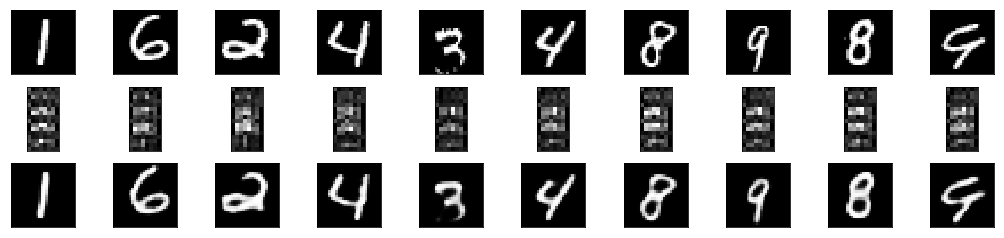

In [0]:
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(16, 8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Denoising Images with the Convolutional Autoencoder

Earlier, I mentioned that autoencoders are useful for denoising data including images. When I learned about this concept in grad school, my mind was blown. This simple task helped me realize data can be manipulated in very useful ways and that the dirty data we often inherit can be cleansed using more advanced techniques.

With that in mind, let's add bit of noise to the test images and see how good the convolutional autoencoder is at removing the noise.

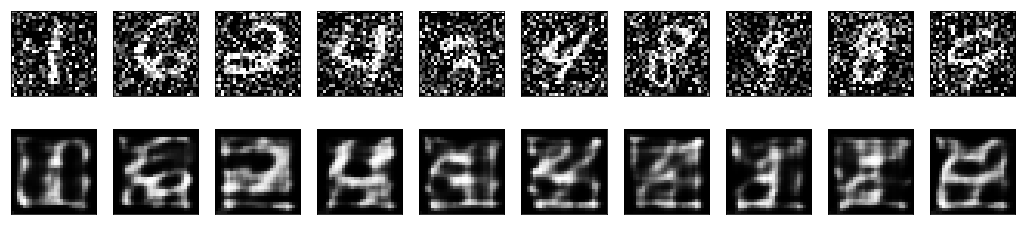

In [0]:
x_train_noisy = x_train + np.random.normal(loc=0.0, scale=0.5, size=x_train.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)

x_test_noisy = x_test + np.random.normal(loc=0.0, scale=0.5, size=x_test.shape)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

# Denoise test images
x_test_denoised = autoencoder.predict(x_test_noisy)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(x_test_noisy[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot reconstructed image
    ax = plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(x_test_denoised[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Convolutional Autoencoder - Take 2

Well, those images are terrible. They remind me of the mask from the movie Scream.

![Scream mask](https://ae01.alicdn.com/kf/HTB1ZxqFj6ihSKJjy0Feq6zJtpXaS/New-Scary-Ghost-Face-Scream-Mask-Creepy-for-Halloween-Masquerade-Party-Fancy-Dress-Costume.jpg)

Okay, so let's try that again. This time we're going to build a ConvNet with a lot more parameters and forego visualizing the encoding layer. The network will be a bit larger and slower to train, but the results are definitely worth the effort.

One more thing: this time, let's use `(x_train_noisy, x_train)` as training data and `(x_test_noisy, x_test)` as validation data.

In [0]:
autoencoder = Sequential()

# Encoder Layers
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))

# Decoder Layers
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 32)        9248      
__________

In [0]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 140s 2ms/step - loss: 0.1661 - val_loss: 0.1143
Epoch 2/100
60000/60000 [==============================] - 132s 2ms/step - loss: 0.1113 - val_loss: 0.1068
Epoch 3/100
60000/60000 [==============================] - 133s 2ms/step - loss: 0.1062 - val_loss: 0.1038
Epoch 4/100
60000/60000 [==============================] - 131s 2ms/step - loss: 0.1036 - val_loss: 0.1017
Epoch 5/100
60000/60000 [==============================] - 119s 2ms/step - loss: 0.1018 - val_loss: 0.1001
Epoch 6/100
60000/60000 [==============================] - 121s 2ms/step - loss: 0.1005 - val_loss: 0.0992
Epoch 7/100
60000/60000 [==============================] - 121s 2ms/step - loss: 0.0996 - val_loss: 0.0984
Epoch 8/100
60000/60000 [==============================] - 123s 2ms/step - loss: 0.0989 - val_loss: 0.0980
Epoch 9/100
60000/60000 [==============================] - 128s 2ms/step - loss: 0.0983 - val_

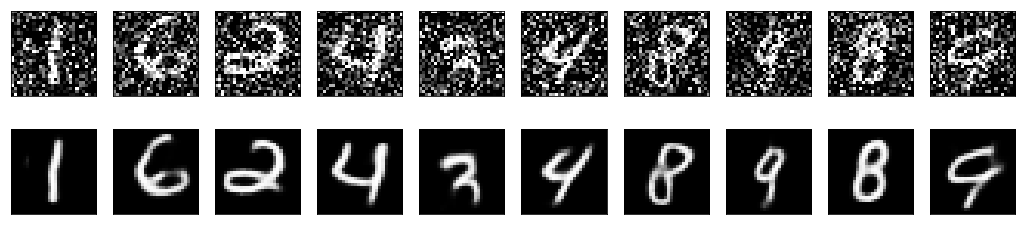

In [0]:
# Denoise test images
x_test_denoised = autoencoder.predict(x_test_noisy)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(x_test_noisy[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot reconstructed image
    ax = plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(x_test_denoised[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Fantastic, those images almost look like the originals.